In [1]:
import os, glob
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/lk57288c/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -----------------------------
# User-provided paths and device
# -----------------------------
train_image_dirs = [
    "DRIVE_AV/training/images",
    "HRF_AV/training/images",
    "LES_AV/training/images",
]
train_label_dirs = [
    "DRIVE_AV/training/label",
    "HRF_AV/training/label",
    "LES_AV/training/label",
]
train_mask_dirs = [
    "DRIVE_AV/training/mask",
    "HRF_AV/training/mask",
    "LES_AV/training/mask",
]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# Consolidate all datasets
# -----------------------------
OUT_ROOT = "AV_MERGED"
IMG_OUT = f"{OUT_ROOT}/images"
LAB_OUT = f"{OUT_ROOT}/labels"
MSK_OUT = f"{OUT_ROOT}/masks"
os.makedirs(IMG_OUT, exist_ok=True)
os.makedirs(LAB_OUT, exist_ok=True)
os.makedirs(MSK_OUT, exist_ok=True)

def stem(p):
    return Path(p).stem

def find_by_stem(dirpath, s):
    for ext in ("*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"):
        cands = glob.glob(os.path.join(dirpath, f"{s}*"))
        if cands:
            # prefer exact stem match
            exact = [c for c in cands if Path(c).stem == s]
            return exact[0] if exact else cands[0]
    return None

def copy_and_standardize(img_p, lab_p, msk_p, prefix, idx):
    # Read and write as PNG to standardize
    img = cv2.imread(img_p, cv2.IMREAD_COLOR)
    lab = cv2.imread(lab_p, cv2.IMREAD_COLOR)
    msk = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)
    img_name = f"{prefix}_{idx:04d}.png"
    lab_name = f"{prefix}_{idx:04d}.png"
    msk_name = f"{prefix}_{idx:04d}.png"
    cv2.imwrite(os.path.join(IMG_OUT, img_name), img)
    cv2.imwrite(os.path.join(LAB_OUT, lab_name), lab)
    cv2.imwrite(os.path.join(MSK_OUT, msk_name), msk)

def consolidate(all_img_dirs, all_lab_dirs, all_msk_dirs):
    counter = 0
    for im_dir, lb_dir, mk_dir in zip(all_img_dirs, all_lab_dirs, all_msk_dirs):
        prefix = Path(im_dir).parts[-3] if "AV" in Path(im_dir).parts[-2] else Path(im_dir).parts[-2]
        img_files = sorted([p for p in glob.glob(os.path.join(im_dir, "*")) if Path(p).is_file()])
        for img_p in tqdm(img_files, desc=f"Merging {prefix}"):
            s = stem(img_p)
            lab_p = find_by_stem(lb_dir, s)
            msk_p = find_by_stem(mk_dir, s)
            if lab_p is None or msk_p is None:
                continue
            counter += 1
            copy_and_standardize(img_p, lab_p, msk_p, prefix, counter)

# consolidate(train_image_dirs, train_label_dirs, train_mask_dirs)

In [3]:
# -----------------------------
# Constants and color encoding
# -----------------------------
IGNORE_INDEX = 255  # ignore green crossings & white-uncertain

def encode_label_rgb_to_ids(label_bgr: np.ndarray) -> np.ndarray:
    """Map RGB colors to {0:bg,1:artery,2:vein,255:ignore}."""
    lab = cv2.cvtColor(label_bgr, cv2.COLOR_BGR2RGB)
    R, G, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    ids = np.zeros(R.shape, dtype=np.uint8)
    red   = (R > 200) & (G < 60) & (B < 60)    # artery
    blue  = (B > 200) & (R < 60) & (G < 60)    # vein
    green = (G > 200) & (R < 60) & (B < 60)    # overlap -> ignore
    white = (R > 200) & (G > 200) & (B > 200)  # uncertain -> ignore
    ids[red]  = 1
    ids[blue] = 2
    ids[green | white] = IGNORE_INDEX
    return ids

def decode_ids_to_rgb(ids: np.ndarray) -> np.ndarray:
    """Map ids back to RGB for visualization (artery red, vein blue)."""
    out = np.zeros((*ids.shape, 3), dtype=np.uint8)
    out[ids == 1] = (255, 0, 0)  # artery
    out[ids == 2] = (0, 0, 255)  # vein
    return out

def clahe_on_green(img_bgr: np.ndarray) -> np.ndarray:
    """CLAHE on green channel to enhance vessels, then return BGR."""
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    g = rgb[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    rgb[:, :, 1] = clahe.apply(g)
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

In [4]:
# -----------------------------
# Label encoding/decoding
# -----------------------------
IGNORE_INDEX = 255  # for crossings (green) and uncertain (white)
# Color thresholds
def encode_label_rgb_to_ids(label_bgr):
    lab = cv2.cvtColor(label_bgr, cv2.COLOR_BGR2RGB)
    R, G, B = lab[:,:,0], lab[:,:,1], lab[:,:,2]
    h, w = R.shape
    ids = np.zeros((h,w), dtype=np.uint8)  # 0 background
    red   = (R>200) & (G<60) & (B<60)      # artery -> 1
    blue  = (B>200) & (R<60) & (G<60)      # vein -> 2
    green = (G>200) & (R<60) & (B<60)      # overlap -> ignore
    white = (R>200) & (G>200) & (B>200)    # uncertain -> ignore
    ids[red]  = 1
    ids[blue] = 2
    ids[green | white] = IGNORE_INDEX
    return ids

def decode_ids_to_rgb(ids):
    h, w = ids.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    out[ids==1] = (255,0,0)  # red for artery
    out[ids==2] = (0,0,255)  # blue for vein
    # background remains black; ignored pixels not rendered
    return out

# -----------------------------
# CLAHE on green channel
# -----------------------------
def clahe_on_green(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    g = img_rgb[:,:,1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g_eq = clahe.apply(g)
    img_rgb[:,:,1] = g_eq
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

In [5]:
# -----------------------------
# Dataset
# -----------------------------
class MultiAVSegDataset(Dataset):
    def __init__(self, root, split="train", img_size=512, use_aug=True):
        self.img_dir = f"{root}/images"
        self.lab_dir = f"{root}/labels"
        self.msk_dir = f"{root}/masks"
        self.files = sorted([Path(p).name for p in glob.glob(os.path.join(self.img_dir, "*.png"))])
        n = len(self.files)
        # 90/10 split if only training is given; adjust as needed
        cut = int(0.9*n)
        self.files = self.files[:cut] if split=="train" else self.files[cut:]
        self.img_size = img_size
        self.use_aug = use_aug and (split=="train")

        self.train_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, p=1.0),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_REFLECT, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=25,
                               border_mode=cv2.BORDER_REFLECT, p=0.75),
            A.ElasticTransform(alpha=50, sigma=8, alpha_affine=8, p=0.2),
            A.RandomBrightnessContrast(0.2,0.2,p=0.5),
            A.ColorJitter(0.1,0.1,0.1,0.05,p=0.3),
            A.GaussianBlur(blur_limit=(3,5), p=0.2),
            A.CoarseDropout(max_holes=8, max_height=img_size//16, max_width=img_size//16,
                            min_holes=2, fill_value=0, mask_fill_value=0, p=0.2),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])
        self.val_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, p=1.0),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_REFLECT, p=1.0),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img_p = os.path.join(self.img_dir, name)
        lab_p = os.path.join(self.lab_dir, name)
        msk_p = os.path.join(self.msk_dir, name)

        img = cv2.imread(img_p, cv2.IMREAD_COLOR)
        lab_rgb = cv2.imread(lab_p, cv2.IMREAD_COLOR)
        fov = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)

        # preprocess
        img = clahe_on_green(img)  # enhance vessels on green
        # encode labels
        lab_ids = encode_label_rgb_to_ids(lab_rgb)
        # apply FOV: set outside-FOV to ignore_index
        fov_bin = (fov > 127).astype(np.uint8)
        lab_ids[fov_bin==0] = IGNORE_INDEX

        # Albumentations expects mask as HxW
        tf = self.train_tf if self.use_aug else self.val_tf
        out = tf(image=img, mask=lab_ids)
        image, mask = out["image"], out["mask"].long()
        return image, mask, name


In [6]:
# -----------------------------
# Data consolidation (optional)
# -----------------------------
def consolidate_datasets(image_dirs, label_dirs, mask_dirs, out_root):
    """Copy to unified PNG folders: images/, labels/, masks/."""
    IMG_OUT, LAB_OUT, MSK_OUT = [os.path.join(out_root, p) for p in ["images","labels","masks"]]
    for d in [IMG_OUT, LAB_OUT, MSK_OUT]: os.makedirs(d, exist_ok=True)

    def _stem(p): return Path(p).stem
    def _find(dirp, s):
        for ext in ("*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"):
            c = glob.glob(os.path.join(dirp, f"{s}*"))
            if c:
                exact = [x for x in c if Path(x).stem == s]
                return exact[0] if exact else c[0]
        return None

    k = 0
    for imd, lbd, mkd in zip(image_dirs, label_dirs, mask_dirs):
        prefix = Path(imd).parts[-3] if len(Path(imd).parts) >= 3 else Path(imd).parts[-1]
        imgs = sorted([p for p in glob.glob(os.path.join(imd, "*")) if Path(p).is_file()])
        for ip in tqdm(imgs, desc=f"Merge {prefix}"):
            s = _stem(ip)
            lp, mp = _find(lbd, s), _find(mkd, s)
            if lp is None or mp is None: continue
            img = cv2.imread(ip, cv2.IMREAD_COLOR)
            lab = cv2.imread(lp, cv2.IMREAD_COLOR)
            msk = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
            k += 1
            name = f"{prefix}_{k:04d}.png"
            cv2.imwrite(os.path.join(IMG_OUT, name), img)
            cv2.imwrite(os.path.join(LAB_OUT, name), lab)
            cv2.imwrite(os.path.join(MSK_OUT, name), msk)
    return os.path.join(out_root, "images"), os.path.join(out_root, "labels"), os.path.join(out_root, "masks")

# -----------------------------
# Dataset with synchronized FOV
# -----------------------------
class AVSegDataset(Dataset):
    """
    Returns (image_tensor, label_ids_tensor, fov_tensor, filename)
    - label ids: 0 bg, 1 artery, 2 vein, 255 ignore
    - fov: 0/1 mask, goes through identical geometric transforms via additional_targets
    """
    def __init__(self, root, split="train", img_size=512, use_aug=True):
        self.img_dir = os.path.join(root, "images")
        self.lab_dir = os.path.join(root, "labels")
        self.msk_dir = os.path.join(root, "masks")
        self.files = sorted([Path(p).name for p in glob.glob(os.path.join(self.img_dir, "*.png"))])
        n = len(self.files)
        cut = int(0.9 * n)
        self.files = self.files[:cut] if split == "train" else self.files[cut:]
        self.img_size = img_size
        self.use_aug = use_aug and (split == "train")

        self.train_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, p=1.0),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_REFLECT, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=25,
                               border_mode=cv2.BORDER_REFLECT, p=0.75),
            A.ElasticTransform(alpha=50, sigma=8, alpha_affine=8, p=0.2),
            A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
            A.ColorJitter(0.1, 0.1, 0.1, 0.05, p=0.3),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.CoarseDropout(max_holes=8, max_height=img_size//16, max_width=img_size//16,
                            min_holes=2, fill_value=0, mask_fill_value=0, p=0.2),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ], additional_targets={'fov': 'mask'})  # synchronized FOV

        self.val_tf = A.Compose([
            A.LongestMaxSize(max_size=img_size, p=1.0),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_REFLECT, p=1.0),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ], additional_targets={'fov': 'mask'})  # synchronized FOV

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        ip = os.path.join(self.img_dir, name)
        lp = os.path.join(self.lab_dir, name)
        mp = os.path.join(self.msk_dir, name)

        img = cv2.imread(ip, cv2.IMREAD_COLOR)
        lab_rgb = cv2.imread(lp, cv2.IMREAD_COLOR)
        fov = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)

        # preprocess
        img = clahe_on_green(img)
        lab_ids = encode_label_rgb_to_ids(lab_rgb)

        fov_bin = (fov > 127).astype(np.uint8)
        # Make outside-FOV ignored for loss; alternatively set to 0 to teach background
        lab_ids[fov_bin == 0] = IGNORE_INDEX

        tf = self.train_tf if self.use_aug else self.val_tf
        out = tf(image=img, mask=lab_ids, fov=fov_bin)
        image = out["image"]
        label = out["mask"].long()
        fov_t = out["fov"].float()
        return image, label, fov_t, name

In [8]:
# -------- losses (CE with class weights + Dice over classes 1,2,3) --------
class MultiClassDiceLoss(nn.Module):
    def __init__(self, classes=(1,2,3), smooth=1e-5):
        super().__init__()
        self.classes = classes
        self.smooth = smooth
    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        valid = (target != IGNORE_INDEX)
        if valid.sum()==0: return logits.sum()*0
        loss = 0.0
        for c in self.classes:
            pc = probs[:,c,:,:][valid]
            tc = (target==c).float()[valid]
            inter = (pc*tc).sum()
            den = pc.sum()+tc.sum()
            loss += 1 - (2*inter + self.smooth)/(den + self.smooth)
        return loss/len(self.classes)

# class weights: background under-weighted, crossing moderately weighted
def make_criterion():
    w = torch.tensor([0.2, 1.0, 1.0, 0.6], dtype=torch.float32)  # [bg, a, v, cross]
    ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX, weight=w.to(device))
    dice = MultiClassDiceLoss(classes=(1,2,3))
    return ce, dice


In [9]:
# -----------------------------
# Model factory
# -----------------------------
def make_model(arch="unet", encoder="resnet34", num_classes=3):
    if arch.lower().replace("+","") in ["unetpp","unetplusplus","unet++"]:
        return smp.UnetPlusPlus(encoder_name=encoder, encoder_weights="imagenet",
                                in_channels=3, classes=num_classes)
    return smp.Unet(encoder_name=encoder, encoder_weights="imagenet",
                    in_channels=3, classes=num_classes)

# -----------------------------
# Losses
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5): super().__init__(); self.smooth = smooth
    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        valid = (target != IGNORE_INDEX)
        if valid.sum() == 0: return logits.sum()*0
        loss = 0.0
        for c in [1, 2]:
            pc = probs[:, c, :, :][valid]
            tc = (target == c).float()[valid]
            inter = (pc * tc).sum()
            den = pc.sum() + tc.sum()
            loss += 1 - (2*inter + self.smooth) / (den + self.smooth)
        return loss / 2


In [11]:
# -----------------------------
# Training / validation
# -----------------------------
def train_one_epoch(model, loader, optim, ce_loss, dice_loss, scaler, device):
    model.train()
    total = 0.0
    for img, lab, fov, _ in tqdm(loader, leave=False, desc="train"):
        img, lab = img.to(device), lab.to(device)
        optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(img)
            loss = ce_loss(logits, lab) + 0.5*dice_loss(logits, lab)
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        total += loss.item() * img.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    inter = {1:0, 2:0}; union = {1:0, 2:0}
    for img, lab, fov, _ in tqdm(loader, leave=False, desc="valid"):
        img, lab, fov = img.to(device), lab.to(device), (fov.to(device) > 0.5)
        logits = model(img)
        pred = logits.argmax(1)
        # evaluate inside FOV only and excluding ignore_index
        valid = (lab != IGNORE_INDEX) & fov
        for c in [1, 2]:
            p = (pred == c) & valid
            t = (lab == c) & valid
            inter[c] += (p & t).sum().item()
            union[c] += (p | t).sum().item()
    iou_a = inter[1] / (union[1] + 1e-7)
    iou_v = inter[2] / (union[2] + 1e-7)
    miou = (iou_a + iou_v) / 2
    return miou, iou_a, iou_v

def fit(model, train_loader, val_loader, epochs, lr, device, save_path):
    ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    dice = DiceLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    best = -1
    for ep in range(1, epochs+1):
        tr = train_one_epoch(model, train_loader, opt, ce, dice, scaler, device)
        miou, ia, iv = validate(model, val_loader, device)
        print(f"Epoch {ep}: loss={tr:.4f} mIoU={miou:.4f} (A={ia:.4f}, V={iv:.4f})")
        if miou > best:
            best = miou
            torch.save(model.state_dict(), save_path)
    return best

# -----------------------------
# Inference (hard-mask outside FOV)
# -----------------------------
@torch.no_grad()
def predict_and_save(model, loader, device, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    for img, _, fov, names in tqdm(loader, leave=False, desc="infer"):
        img = img.to(device)
        logits = model(img)
        pred = logits.argmax(1).cpu().numpy()
        fovs = (fov.numpy() > 0.5).astype(np.uint8)
        for p, f, name in zip(pred, fovs, names):
            p[f == 0] = 0  # force background outside FOV
            color = decode_ids_to_rgb(p.astype(np.uint8))
            cv2.imwrite(os.path.join(out_dir, name), cv2.cvtColor(color, cv2.COLOR_RGB2BGR))

# -----------------------------
# Dataloaders helper
# -----------------------------
def make_loaders(root, size=512, batch=4, workers=4, use_aug=True):
    tr = AVSegDataset(root, split="train", img_size=size, use_aug=use_aug)
    va = AVSegDataset(root, split="val", img_size=size, use_aug=False)
    tr_dl = DataLoader(tr, batch_size=batch, shuffle=True, num_workers=workers, pin_memory=True)
    va_dl = DataLoader(va, batch_size=batch, shuffle=False, num_workers=workers, pin_memory=True)
    return tr_dl, va_dl

In [ ]:
root = "AV_MERGED"        # where images/, labels/, masks/ exist
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader = make_loaders(root, size=512, batch=4, workers=4, use_aug=True)

model = make_model(arch="unet++", encoder="resnet34", num_classes=3).to(device)
ckpt = f"{root}/best_unetpp.pt"
best_miou = fit(model, train_loader, val_loader, epochs=50, lr=3e-4, device=device, save_path=ckpt)

# reload best and save masked color predictions
best = make_model(arch="unet++", encoder="resnet34", num_classes=3).to(device)
best.load_state_dict(torch.load(ckpt, map_location=device))
predict_and_save(best, val_loader, device, out_dir=f"{root}/pred_unetpp")


/home/lk57288c/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_3644994/4018086714.py:63: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=50, sigma=8, alpha_affine=8, p=0.2),
/tmp/ipykernel_3644994/4018086714.py:67: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=img_size//16, max_width=img_size//16,


Epoch 1: loss=1.1290 mIoU=0.0579 (A=0.0464, V=0.0694)


Epoch 2: loss=0.8505 mIoU=0.1061 (A=0.0948, V=0.1174)


Epoch 3: loss=0.7465 mIoU=0.2086 (A=0.1079, V=0.3092)


Epoch 4: loss=0.6957 mIoU=0.2380 (A=0.1138, V=0.3621)


Epoch 5: loss=0.6525 mIoU=0.2460 (A=0.1202, V=0.3718)


Epoch 6: loss=0.6273 mIoU=0.2986 (A=0.1885, V=0.4086)


Epoch 7: loss=0.6049 mIoU=0.3279 (A=0.2357, V=0.4200)


Epoch 8: loss=0.5821 mIoU=0.3539 (A=0.2950, V=0.4128)


Epoch 9: loss=0.5631 mIoU=0.3737 (A=0.3213, V=0.4261)


Epoch 10: loss=0.5489 mIoU=0.3780 (A=0.3361, V=0.4199)


Epoch 11: loss=0.5339 mIoU=0.3870 (A=0.3278, V=0.4462)


Epoch 12: loss=0.5320 mIoU=0.4017 (A=0.3607, V=0.4427)


Epoch 13: loss=0.5270 mIoU=0.3693 (A=0.3479, V=0.3908)


Epoch 14: loss=0.5147 mIoU=0.4290 (A=0.3877, V=0.4702)


Epoch 15: loss=0.4958 mIoU=0.4266 (A=0.3789, V=0.4743)


Epoch 16: loss=0.4944 mIoU=0.4123 (A=0.3750, V=0.4497)


Epoch 17: loss=0.4794 mIoU=0.4305 (A=0.3876, V=0.4734)


Epoch 18: loss=0.4752 mIoU=0.4171 (A=0.3743, V=0.4598)


Epoch 19: loss=0.4676 mIoU=0.4322 (A=0.3818, V=0.4826)


Epoch 20: loss=0.4673 mIoU=0.4277 (A=0.3809, V=0.4744)


Epoch 21: loss=0.4527 mIoU=0.4528 (A=0.4069, V=0.4987)


Epoch 22: loss=0.4440 mIoU=0.4646 (A=0.4246, V=0.5047)


Epoch 23: loss=0.4423 mIoU=0.4663 (A=0.4231, V=0.5095)


Epoch 24: loss=0.4368 mIoU=0.4483 (A=0.3916, V=0.5050)


Epoch 25: loss=0.4362 mIoU=0.4742 (A=0.4421, V=0.5064)


Epoch 26: loss=0.4364 mIoU=0.4925 (A=0.4563, V=0.5288)


Epoch 27: loss=0.4348 mIoU=0.4849 (A=0.4427, V=0.5270)


Epoch 28: loss=0.4332 mIoU=0.5001 (A=0.4533, V=0.5468)


Epoch 29: loss=0.4221 mIoU=0.4927 (A=0.4484, V=0.5369)


Epoch 30: loss=0.4211 mIoU=0.4516 (A=0.4203, V=0.4830)


Epoch 31: loss=0.4222 mIoU=0.4777 (A=0.4390, V=0.5163)


Epoch 32: loss=0.4318 mIoU=0.4857 (A=0.4555, V=0.5159)


Epoch 33: loss=0.4322 mIoU=0.4748 (A=0.4330, V=0.5166)


Epoch 34: loss=0.4148 mIoU=0.4855 (A=0.4483, V=0.5227)


Epoch 35: loss=0.4076 mIoU=0.4833 (A=0.4450, V=0.5215)


Epoch 36: loss=0.4075 mIoU=0.4971 (A=0.4648, V=0.5295)


Epoch 37: loss=0.3987 mIoU=0.5181 (A=0.4844, V=0.5518)


Epoch 38: loss=0.3982 mIoU=0.4930 (A=0.4501, V=0.5358)


Epoch 39: loss=0.4044 mIoU=0.4956 (A=0.4630, V=0.5283)


Epoch 40: loss=0.4002 mIoU=0.4855 (A=0.4497, V=0.5214)


Epoch 41: loss=0.3895 mIoU=0.4739 (A=0.4474, V=0.5004)


Epoch 42: loss=0.3880 mIoU=0.4965 (A=0.4634, V=0.5296)


Epoch 43: loss=0.3911 mIoU=0.5152 (A=0.4771, V=0.5533)


Epoch 44: loss=0.3908 mIoU=0.5075 (A=0.4697, V=0.5453)


Epoch 45: loss=0.3829 mIoU=0.4889 (A=0.4460, V=0.5317)


Epoch 46: loss=0.3893 mIoU=0.5093 (A=0.4771, V=0.5415)


Epoch 47: loss=0.3791 mIoU=0.5050 (A=0.4723, V=0.5377)


Epoch 48: loss=0.3828 mIoU=0.5040 (A=0.4721, V=0.5359)


Epoch 49: loss=0.3751 mIoU=0.5117 (A=0.4763, V=0.5471)


Epoch 50: loss=0.3767 mIoU=0.5180 (A=0.4842, V=0.5518)


# Test

In [13]:
# eval_av_fixed.py
import os, glob, json
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

IGNORE_INDEX = 255

def encode_label_rgb_to_ids(label_bgr):
    lab = cv2.cvtColor(label_bgr, cv2.COLOR_BGR2RGB)
    R, G, B = lab[:,:,0], lab[:,:,1], lab[:,:,2]
    ids = np.zeros(R.shape, dtype=np.uint8)
    red   = (R>200) & (G<60) & (B<60)      # artery
    blue  = (B>200) & (R<60) & (G<60)      # vein
    green = (G>200) & (R<60) & (B<60)      # overlap -> ignore
    white = (R>200) & (G>200) & (B>200)    # uncertain -> ignore
    ids[red]  = 1
    ids[blue] = 2
    ids[green | white] = IGNORE_INDEX
    return ids

def decode_ids_to_rgb(ids):
    out = np.zeros((*ids.shape,3), dtype=np.uint8)
    out[ids==1] = (255,0,0)   # artery red
    out[ids==2] = (0,0,255)   # vein blue
    return out

def clahe_on_green(img_bgr):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    g = rgb[:,:,1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    rgb[:,:,1] = clahe.apply(g)
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def make_model(arch="unet++", encoder="resnet34", num_classes=3):
    if arch.lower().replace("+","") in ["unetpp","unetplusplus","unet++"]:
        return smp.UnetPlusPlus(encoder_name=encoder, encoder_weights=None,
                                in_channels=3, classes=num_classes)
    return smp.Unet(encoder_name=encoder, encoder_weights=None,
                    in_channels=3, classes=num_classes)

class AVTestDataset(Dataset):
    """
    Returns (image_tensor, label_ids_tensor, fov_tensor, filename)
    FOV goes through identical transforms via additional_targets.
    """
    def __init__(self, image_dir, label_dir, mask_dir, img_size=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.mask_dir  = mask_dir
        self.files = sorted([Path(p).name for p in glob.glob(os.path.join(image_dir, "*")) if Path(p).is_file()])
        self.img_size = img_size
        tf_list = []
        if img_size is not None:
            tf_list += [
                A.LongestMaxSize(max_size=img_size, p=1.0),
                A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_REFLECT, p=1.0),
            ]
        tf_list += [
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ]
        self.tf = A.Compose(tf_list, additional_targets={'fov':'mask'})

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        ip = os.path.join(self.image_dir, name)
        lp = os.path.join(self.label_dir, name)
        mp = os.path.join(self.mask_dir, name)

        img = cv2.imread(ip, cv2.IMREAD_COLOR)
        lab_rgb = cv2.imread(lp, cv2.IMREAD_COLOR)
        fov = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)

        img = clahe_on_green(img)
        lab_ids = encode_label_rgb_to_ids(lab_rgb)
        fov_bin = (fov > 127).astype(np.uint8)
        lab_ids[fov_bin==0] = IGNORE_INDEX  # ignore outside FOV

        out = self.tf(image=img, mask=lab_ids, fov=fov_bin)
        image = out["image"]
        label = out["mask"].long()
        fov_t = out["fov"].float()
        return image, label, fov_t, name

@torch.no_grad()
def evaluate_and_plot(checkpoint_path,
                      image_dir, label_dir, mask_dir,
                      out_dir, arch="unet++", encoder="resnet34",
                      device=None, img_size=None):
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.join(out_dir, "plots"), exist_ok=True)
    device = device or torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = make_model(arch=arch, encoder=encoder, num_classes=3).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    ds = AVTestDataset(image_dir, label_dir, mask_dir, img_size=img_size)
    dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

    inter = {1:0, 2:0}; union = {1:0, 2:0}
    dice_num = {1:0, 2:0}; dice_den = {1:0, 2:0}

    for img, lab, fov, name in tqdm(dl, desc="Test"):
        img, lab, fov = img.to(device), lab.to(device), (fov.to(device) > 0.5)

        # forward
        logits = model(img)
        pred = logits.argmax(1)

        # metrics inside FOV and excluding ignore_index
        valid = (lab != IGNORE_INDEX) & fov
        for c in [1,2]:
            p = (pred == c) & valid
            t = (lab == c) & valid
            tp = (p & t).sum().item()
            u  = (p | t).sum().item()
            inter[c] += tp
            union[c] += u
            dice_num[c] += 2*tp
            dice_den[c] += p.sum().item() + t.sum().item()

        # Visualization: read raw for true H,W ints (avoid tensor dsize)
        raw = cv2.imread(os.path.join(image_dir, name[0]), cv2.IMREAD_COLOR)
        raw_rgb = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
        H, W = int(raw_rgb.shape[0]), int(raw_rgb.shape[1])

        # color GT for display
        gt_np = lab.squeeze(0).cpu().numpy()
        gt_np[gt_np==IGNORE_INDEX] = 0
        color_gt = decode_ids_to_rgb(gt_np.astype(np.uint8))

        # color pred with hard FOV mask
        p_np = pred.squeeze(0).cpu().numpy()
        f_np = fov.squeeze(0).cpu().numpy().astype(np.uint8)
        p_np[f_np==0] = 0
        color_pred = decode_ids_to_rgb(p_np.astype(np.uint8))

        # resize to original dimensions if needed
        if img_size is not None:
            color_pred = cv2.resize(color_pred, (W, H), interpolation=cv2.INTER_NEAREST)
            color_gt   = cv2.resize(color_gt,   (W, H), interpolation=cv2.INTER_NEAREST)

        # side-by-side plot
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(raw_rgb);    axs[0].set_title("Image");   axs[0].axis("off")
        axs[1].imshow(color_gt);   axs[1].set_title("GT A/V");  axs[1].axis("off")
        axs[2].imshow(color_pred); axs[2].set_title("Pred A/V");axs[2].axis("off")
        fig.tight_layout()
        plt.savefig(os.path.join(out_dir, "plots", name[0]))
        plt.close(fig)

        # save raw prediction PNG
        cv2.imwrite(os.path.join(out_dir, name[0]),
                    cv2.cvtColor(color_pred, cv2.COLOR_RGB2BGR))

    iou_a = inter[1] / (union[1] + 1e-7)
    iou_v = inter[2] / (union[2] + 1e-7)
    miou  = (iou_a + iou_v) / 2.0

    dice_a = dice_num[1] / (dice_den[1] + 1e-7)
    dice_v = dice_num[2] / (dice_den[2] + 1e-7)
    mdice  = (dice_a + dice_v) / 2.0

    print(f"mIoU={miou:.4f} IoU_A={iou_a:.4f} IoU_V={iou_v:.4f}")
    print(f"mDice={mdice:.4f} Dice_A={dice_a:.4f} Dice_V={dice_v:.4f}")

    with open(os.path.join(out_dir, "metrics.json"), "w") as f:
        json.dump({"IoU":{"artery":iou_a,"vein":iou_v,"mean":miou},
                   "Dice":{"artery":dice_a,"vein":dice_v,"mean":mdice}}, f, indent=2)


In [ ]:
CKPT = "AV_MERGED/best_unetpp.pt"
OUT  = "AV_MERGED/HRF_AV_TEST_PRED"

evaluate_and_plot(
    checkpoint_path=CKPT,
    image_dir="HRF_AV/test/images",
    label_dir="HRF_AV/test/label",
    mask_dir ="HRF_AV/test/mask",
    out_dir=OUT,
    arch="unet++",
    encoder="resnet34",
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    img_size=1024
)


Test: 100%|██████████| 30/30 [00:44<00:00,  1.50s/it]

mIoU=0.4796 IoU_A=0.4417 IoU_V=0.5174
mDice=0.6474 Dice_A=0.6128 Dice_V=0.6819


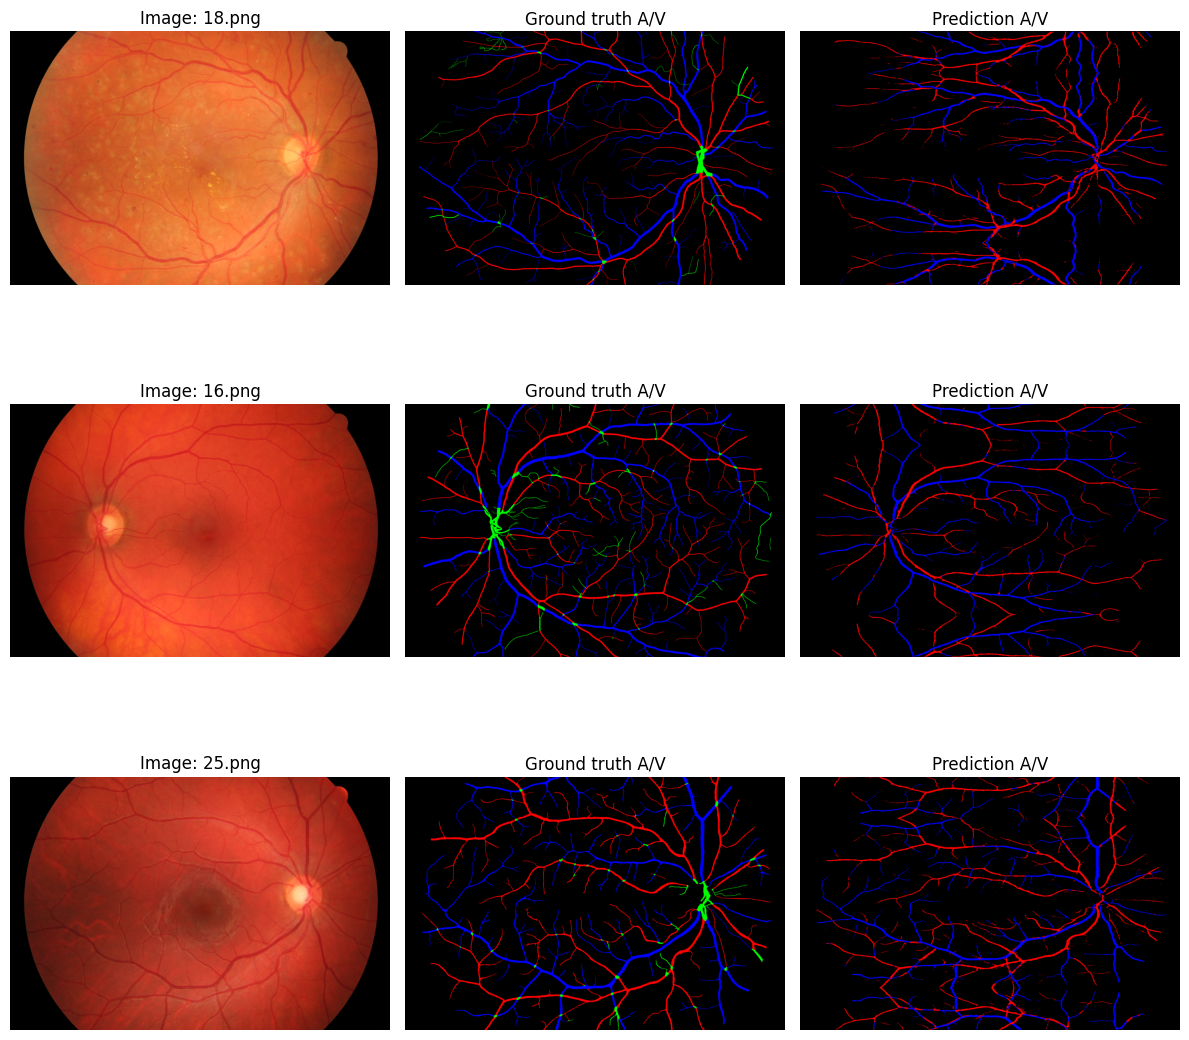

In [ ]:
# plot_triplets.py
import os, glob, random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

IMG_DIR = "HRF_AV/test/images"
GT_DIR  = "HRF_AV/test/label"
PR_DIR  = "AV_MERGED/HRF_AV_TEST_PRED"

# collect common filenames across the three folders
def list_names(folder):
    return {Path(p).name for p in glob.glob(os.path.join(folder, "*")) if Path(p).is_file()}

common = list(list_names(IMG_DIR) & list_names(GT_DIR) & list_names(PR_DIR))
assert len(common) >= 3, f"Need at least 3 common files, found {len(common)}"

# pick 3 at random (or slice first 3)
random.seed(0)
pick = random.sample(common, 3)

def read_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# plot
fig, axes = plt.subplots(len(pick), 3, figsize=(12, 4*len(pick)))
if len(pick) == 1:
    axes = [axes]

for r, name in enumerate(pick):
    img = read_rgb(os.path.join(IMG_DIR, name))
    gt  = read_rgb(os.path.join(GT_DIR,  name))
    pr  = read_rgb(os.path.join(PR_DIR,  name))

    axes[r][0].imshow(img); axes[r][0].set_title(f"Image: {name}"); axes[r][0].axis("off")
    axes[r][1].imshow(gt);  axes[r][1].set_title("Ground truth A/V"); axes[r][1].axis("off")
    axes[r][2].imshow(pr);  axes[r][2].set_title("Prediction A/V");   axes[r][2].axis("off")

plt.tight_layout()
plt.show()